In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle

In [2]:
data_dir = 'D:/FileMonHoc/Do_an_chuyen_nganh_KHDL/Bo_du_lieu/chest_xray'

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Các tham số cho mô hình và quá trình huấn luyện
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
EPOCHS = 15 # Tăng số epochs để có kết quả tốt hơn (ví dụ: 20-30)


In [3]:
print("Đang tải dữ liệu huấn luyện...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary', # NORMAL=0, PNEUMONIA=1
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

Đang tải dữ liệu huấn luyện...
Found 5216 files belonging to 2 classes.


In [4]:
print("Đang tải dữ liệu kiểm định...")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Đang tải dữ liệu kiểm định...
Found 16 files belonging to 2 classes.


In [5]:
print("Đang tải dữ liệu kiểm tra...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_dataset.class_names
print("Các lớp được tìm thấy:", class_names)


Đang tải dữ liệu kiểm tra...
Found 624 files belonging to 2 classes.
Các lớp được tìm thấy: ['NORMAL', 'PNEUMONIA']


In [6]:
# Tối ưu hóa hiệu suất tải dữ liệu
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
#Tăng cường dữ liệu
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation",
)

In [8]:
def build_model(num_classes):
    model = Sequential([
        # Input layer
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Chuẩn hóa giá trị pixel về [0, 1]
        layers.Rescaling(1./255),

        # Áp dụng tăng cường dữ liệu
        data_augmentation,

        # Convolutional Block 1
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        # Convolutional Block 2
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        # Convolutional Block 3
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),

        # Chống overfitting
        layers.Dropout(0.2),

        # Flatten để đưa vào lớp fully-connected
        layers.Flatten(),

        # Lớp ẩn
        layers.Dense(256, activation='relu'),

        # Lớp output (1 neuron với hàm sigmoid cho phân loại nhị phân)
        layers.Dense(1, activation='sigmoid')
    ])
    # Biên dịch mô hình
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model

model = build_model(len(class_names))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    15,859,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,953,473 (60.86 MB)

 Trainable params: 15,953,473 (60.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- 5. HUẤN LUYỆN MÔ HÌNH ---
#print("\nBắt đầu quá trình huấn luyện...")
#history = model.fit(
 #   train_dataset,
  #  validation_data=val_dataset,
   # epochs=EPOCHS
#)
#print("Hoàn thành huấn luyện!")


Bắt đầu quá trình huấn luyện...
Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 864s 5s/step - accuracy: 0.7597 - loss: 0.5785 - val_accuracy: 0.5625 - val_loss: 1.1169
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9003 - loss: 0.2395 - val_accuracy: 0.5625 - val_loss: 1.4876
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9142 - loss: 0.2160 - val_accuracy: 0.6875 - val_loss: 1.0951
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9259 - loss: 0.1792 - val_accuracy: 0.5000 - val_loss: 1.7623
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9356 - loss: 0.1724 - val_accuracy: 0.8125 - val_loss: 0.4652
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9505 - loss: 0.1350 - val_accuracy: 0.8750 - val_loss: 0.4054
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9490 - loss: 0.1328 - val_accuracy: 0.9375 - val_loss: 0.3331
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - ac

In [ ]:
# LƯU MÔ HÌNH SAU KHI HUẤN LUYỆN ---
#model_save_path = "/content/gdrive/MyDrive/Do_an_Chuyen_Nganh_KHDL/model3.keras"
#print(f"\nĐang lưu mô hình đã huấn luyện vào file: {model_save_path}")
#model.save(model_save_path)
#print("Lưu mô hình thành công!")


Đang lưu mô hình đã huấn luyện vào file: /content/gdrive/MyDrive/Do_an_Chuyen_Nganh_KHDL/model3.keras
Lưu mô hình thành công!


In [ ]:
# Lưu lịch sử huấn luyện
#history_path = "/content/gdrive/MyDrive/Do_an_Chuyen_Nganh_KHDL/history3.pkl"
#with open(history_path, "wb") as f:
 #   pickle.dump(history.history, f)
#print("✅ Lưu lịch sử huấn luyện thành công!")

✅ Lưu lịch sử huấn luyện thành công!


In [44]:
from tensorflow.keras.models import load_model

model_path = "D:/FileMonHoc/Do_an_chuyen_nganh_KHDL/Bo_du_lieu/model3.keras"
model = load_model(model_path)
print("✅ Đã tải mô hình thành công.")

✅ Đã tải mô hình thành công.


In [10]:
# Đường dẫn chính xác
history_path = "D:/FileMonHoc/Do_an_chuyen_nganh_KHDL/Bo_du_lieu/history3.pkl"

# Load lại file từ đúng đường dẫn
with open(history_path, "rb") as f:
    history_dict = pickle.load(f)

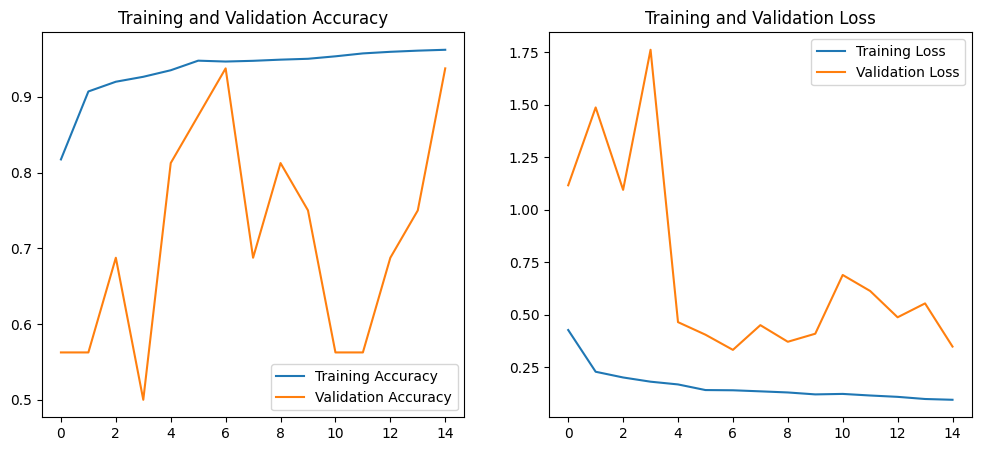

In [13]:
# Trực quan hóa kết quả huấn luyện
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
# Đánh giá trên tập dữ liệu test
print("\nĐánh giá trên dữ liệu test...")
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print(f"\nĐộ chính xác trên tập test: {test_acc*100:.2f}%")


Đánh giá trên dữ liệu test...
20/20 - 2s - 78ms/step - accuracy: 0.8413 - loss: 0.4929

Độ chính xác trên tập test: 84.13%


In [46]:
# --- 7. SỬ DỤNG MÔ HÌNH ĐỂ DỰ ĐOÁN ---
def predict_image(image_path, model):
    """Hàm đọc ảnh, tiền xử lý và dự đoán bệnh lý."""
    try:
        # Đọc ảnh bằng OpenCV
        img = cv2.imread(image_path)
        # Chuyển từ BGR (OpenCV) sang RGB (TensorFlow)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize ảnh về kích thước mà mô hình yêu cầu
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))

        # Chuyển ảnh thành mảng numpy và thêm chiều batch
        img_array = tf.expand_dims(img, 0) # Create a batch

        # Thực hiện dự đoán
        predictions = loaded_model.predict(img_array)
        score = predictions[0][0]

        # Diễn giải kết quả
        confidence = score * 100 if score > 0.5 else (1 - score) * 100
        result = "VIÊM PHỔI (PNEUMONIA)" if score > 0.5 else "BÌNH THƯỜNG (NORMAL)"

        print(f"Ảnh '{os.path.basename(image_path)}' được chẩn đoán là: {result} với độ tin cậy {confidence:.2f}%.")

    except Exception as e:
        print(f"Lỗi khi xử lý ảnh: {e}")

# Lấy một vài ảnh từ tập test để dự đoán thử
# Đường dẫn đến ảnh bình thường
normal_img_path = os.path.join(test_dir, 'NORMAL', 'NORMAL2-IM-0381-0001.jpeg')
# Đường dẫn đến ảnh viêm phổi
pneumonia_img_path = os.path.join(test_dir, 'PNEUMONIA', 'person1_virus_6.jpeg')

print("\n--- BẮT ĐẦU DỰ ĐOÁN ẢNH MỚI ---")
predict_image(normal_img_path, loaded_model)
predict_image(pneumonia_img_path, loaded_model)


--- BẮT ĐẦU DỰ ĐOÁN ẢNH MỚI ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Ảnh 'NORMAL2-IM-0381-0001.jpeg' được chẩn đoán là: BÌNH THƯỜNG (NORMAL) với độ tin cậy 57.62%.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Ảnh 'person1_virus_6.jpeg' được chẩn đoán là: VIÊM PHỔI (PNEUMONIA) với độ tin cậy 99.99%.
